# CSV 파일 읽고 쓰기

In [29]:
# csv 파일로 바꿔봅시다. 
import csv

# https://docs.python.org/2/library/csv.html#csv.reader
# delimiter, qoutechar, qouting 옵션이 뭔지 직접 해봅시다.
with open('sample.csv', 'w') as csvfile:
    # default delimiter는 , quotechar는 "입니다.
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['검사외전', '범죄', '126분'])
    # 아래와 같이 제목에 콤마(,)가 들어가면 delimiter인 콤마(,)와 헷갈리게 됩니다.
    # 그래서 quotechar(|)로 제목을 감싸주게 됩니다.
    # 직접 확인해보죠.
    writer.writerow(['쿵푸팬더3 (Kung Fu Panda 3, 2016)', '애니메이션', '95분'])

In [30]:
# 저장된 csv 파일을 읽고, print 찍어봅시다.
with open('sample.csv', 'r') as csvfile:
    movie_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in movie_reader:
        print row

['\xea\xb2\x80\xec\x82\xac\xec\x99\xb8\xec\xa0\x84', '\xeb\xb2\x94\xec\xa3\x84', '126\xeb\xb6\x84']
['\xec\xbf\xb5\xed\x91\xb8\xed\x8c\xac\xeb\x8d\x943 (Kung Fu Panda 3, 2016)', '\xec\x95\xa0\xeb\x8b\x88\xeb\xa9\x94\xec\x9d\xb4\xec\x85\x98', '95\xeb\xb6\x84']


In [31]:
# 지난주에 배운 movie_total을 csv로 저장해봅시다.

In [32]:
from bs4 import BeautifulSoup as bs
import requests

# 2015-01 ~ 2015-12까지 순회하며 크롤링을 할 것이므로, url 파라미터를 받는 함수를 만듭니다.
def movie_crawler(url):
    res = requests.get(url)

    # 예상치 못하게 404나 500을 받았는데, html을 파싱하려고 하면
    # 에러가 발생하므로, 200(성공)일때만 코드가 실행되도록 합니다.
    if res.status_code == 200:
        soup = bs(res.text)

        # titles = soup.select('#main > div > div.list.detail\
        # > div > table > tbody > tr > td.overview-top > h4 > a')
        # images = soup.select('#img_primary > div > a > div > img')
        #
        # 이렇게 전체 html에서 titles(제목들), images(포스터 이미지들)를 가져오는 대신
        # 하나의 movie 정보를 감싸고 있는 div 태그를 가져온 다음
        # 그 안에 있는 포스터 이미지, 영화 제목, 평점 등을 가져오면
        # for문을 한번만 돌아도됩니다!

        # 이렇게 css selector를 가지고 받아올 수도 있고
        movies = soup.select('#main > div > div.list.detail > div')
        # 이렇게 속성을 가지고 받아올 수도 있습니다.
        movies = soup.findAll('div', {'itemtype': 'http://schema.org/Movie'})

        # title, image, running_time, score, genre, directors, actors 순으로 넣겠습니다.
        table = []
        for movie in movies:
            row = []

            title = movie.findAll('h4', {'itemprop': 'name'})
            image = movie.findAll('img', {'itemprop': 'image'})
            running_time = movie.findAll('time', {'itemprop': 'duration'})
            score = movie.select('div.rating_txt > div > strong')
            genres = movie.findAll('span', {'itemprop': 'genre'})
            directors = movie.findAll('span', {'itemprop': 'director'})
            actors = movie.findAll('span', {'itemprop': 'actors'})

            # strip()은 앞뒤 공백을 지워줍니다.
            # title가 빈 리스트([])인데, title[0]를 하면 index out of range 에러가 납니다.
            # 에러가 나는 것을 방지해주기 위해서 뒤에 len(title)이 0보다 클때만 title[0]를 하게 하고
            # 아니면 "" 빈 스트링을 row에 append 합니다.
            row.append(title[0].text.strip() if len(title)>0 else "")
            row.append(image[0]['src'].strip() if len(image)>0 else "")
            row.append(running_time[0].text.strip() if len(running_time)>0 else "")
            row.append(score[0].text.strip() if len(score)>0 else "")
            # genre, director, actor는 여러명인 경우가 있기 때문에 list로 받아와서 join으로 연결시켜줍니다.
            row.append("/".join([genre.text.strip() for genre in genres]))
            row.append("/".join([director.text.strip() for director in directors]))
            row.append("/".join([actor.text.strip() for actor in actors]))

            # 예상대로라면
            # row <= [u'The Woman in Black 2: Angel of Death (2014)', \
            # 'http://ia.media-imdb.com/images/M/...@._V1_UY209_CR0,0,140,209_AL_.jpg', \
            # u'98 min', \
            # u'42', \
            # Drama/Horror/Thriller, \
            # Tom Harper, \
            # Helen McCrory/Jeremy Irvine/Phoebe Fox/Leanne Best
    
            table.append(row)

        return table

jan_2015 = movie_crawler('http://www.imdb.com/movies-coming-soon/2015-01')
print jan_2015[0]

[u'The Woman in Black 2: Angel of Death (2014)', 'http://ia.media-imdb.com/images/M/MV5BMTgxMjUyNTAxNF5BMl5BanBnXkFtZTgwNTk4MDUyMzE@._V1_UY209_CR0,0,140,209_AL_.jpg', u'98 min', u'42', u'Drama/Horror/Thriller', u'Tom Harper', u'Helen McCrory/Jeremy Irvine/Phoebe Fox/Leanne Best']


In [33]:
# 그러면 이제 2015-01부터 2015-12까지 영화정보를 긁어봅시다.
target_url = 'http://www.imdb.com/movies-coming-soon/{0}'
movie_total = []
for i in range(1,13):
    # string.zfill(2)을 사용해보세요. zero padding이 생깁니다.
    date = "2015-" + str(i).zfill(2)
    print target_url.format(date) + " crawling.."
    movie_total += movie_crawler(target_url.format(date))

http://www.imdb.com/movies-coming-soon/2015-01 crawling..
http://www.imdb.com/movies-coming-soon/2015-02 crawling..
http://www.imdb.com/movies-coming-soon/2015-03 crawling..
http://www.imdb.com/movies-coming-soon/2015-04 crawling..
http://www.imdb.com/movies-coming-soon/2015-05 crawling..
http://www.imdb.com/movies-coming-soon/2015-06 crawling..
http://www.imdb.com/movies-coming-soon/2015-07 crawling..
http://www.imdb.com/movies-coming-soon/2015-08 crawling..
http://www.imdb.com/movies-coming-soon/2015-09 crawling..
http://www.imdb.com/movies-coming-soon/2015-10 crawling..
http://www.imdb.com/movies-coming-soon/2015-11 crawling..
http://www.imdb.com/movies-coming-soon/2015-12 crawling..


In [34]:
with open('movie.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    # utf-8로 인코딩해줍니다.
    writer.writerows([[item.encode('utf-8') for item in row] for row in movie_total])

In [35]:
# 자, 이제 파이썬 데이터 분석툴 pandas 소개합니다.
from pandas import DataFrame

In [36]:
movie_df = DataFrame(movie_total, columns=['title', 'image', 'running time', 'score', 'genre', 'directors', 'actors'])

In [38]:
len(movie_df)

389

In [39]:
# csv format으로 저장하기 (encoding utf-8)
movie_df.to_csv('./movie_from_df.csv', encoding='utf-8', index=False, header=False)

# iPython notebook 설치하기

[iPython 설치 가이드](./ipython_notebook.pdf)

iPython notebook은 현재 보고 있는 이 웹 인터페이스를 지원하고, numpy와 pandas는 파이썬 데이터 분석에 가장 많이 활용되는 패키지입니다. 앞으로 데이터를 다루고 분석하는데 Pandas를 주로 사용하겠지만, Pandas는 numpy 자료구조에 dependency가 있습니다. numpy는 수치 연산에 강력한 ndarray 자료구조와 각종 메소드들을 지원합니다.

# Pandas.DataFrame > Pandas.Series > numpy.ndarray

1. Pandas.DataFrame은 2차원 Data type.
2. Pandas.Series는 index가 있는 1차원 Data type.
3. numpy.ndarray는 파이썬 기본 자료구조인 list보다 훨씬 파워풀한 1차원 Array.

In [274]:
# 일단은 Numpy, Series, DataFrame 관계부터 배워봅시다.
import pandas
import numpy

In [249]:
# Pandas DataFrame 입니다.
pd_df = pandas.DataFrame([[1,2,3],[3,4,5]])
pd_df

,0,1,2
0,1,2,3
1,3,4,5


In [250]:
# Pandas Series 입니다.
pd_sr = pandas.Series([1,2,3])
pd_sr

0    1
1    2
2    3
dtype: int64

In [268]:
# Numpy array 입니다. 
# 중요: numpy.array 메소드로 numpy.ndarray 객체를 생성합니다.
np_ar = numpy.array([1,2,3])
np_ar

array([1, 2, 3])

In [269]:
# Series의 value 값이 Numpy array와 같네요.
pd_sr.values

array([1, 2, 3])

In [271]:
# DataFrame 첫번째 row는 Series와 같네요.
pd_df.ix[0]

0    1
1    2
2    3
Name: 0, dtype: int64

In [277]:
# 그 value 값들이 Numpy array와 같네요.
pd_df.ix[0].values

array([1, 2, 3])

# Pandas

In [275]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [276]:
# DataFrame은 Pandas에 구현되어 있는 기본 자료구조로, 
# 2차원(row, column) 데이터를 표현할 수 있습니다.

# key가 column명, value 하나 하나가 row에 들어갑니다.
data = {
    'name': ['똘기', '떵이', '호치', '새촘'],
    'chinese zodiac': ['Rat', 'Pig', 'Tiger', 'Rabbit'],
    'year': ['1984','1985','1986','1987']
}

df = DataFrame(data)
df

,chinese zodiac,name,year
0,Rat,똘기,1984
1,Pig,떵이,1985
2,Tiger,호치,1986
3,Rabbit,새촘,1987


In [163]:
# column 순서 바꾸기
df = DataFrame(data, columns=['name', 'year', 'chinese zodiac'])
df

,name,year,chinese zodiac
0,똘기,1984,Rat
1,떵이,1985,Pig
2,호치,1986,Tiger
3,새촘,1987,Rabbit


In [164]:
# index(row 명)도 따로 정해줄 수 있습니다.
df = DataFrame(data, \
               columns=['name', 'year', 'chinese zodiac'], \
               index=[1,2,3,4])
df

,name,year,chinese zodiac
1,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [166]:
# column명을 바꾸기 위해서는 
df.columns = ['이름', '년도', '띠']
df

,이름,년도,띠
1,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [204]:
# column을 선택하려면 아래와 같이 합니다.
df['이름']

12-1    똘기
2       떵이
3       호치
4       새촘
Name: 이름, dtype: object

In [208]:
# Series type 입니다. Series의 정체는 뭘까요?
type(df['이름'])

pandas.core.series.Series

In [206]:
# row를 선택하려면 ix 메소드를 통해서 고릅니다. 
# 주의: df.ix[0]은 0이 index로 지정되어있지 않기 때문에 에러가 납니다! 
df.ix[1]

이름        떵이
출생년도    1985
띠        Pig
Name: 2, dtype: object

In [209]:
# 이 녀석도 Series type 입니다.
type(df.ix[1])

pandas.core.series.Series

In [177]:
# column을 확인합니다.
df.columns

Index([u'이름', u'년도', u'띠'], dtype='object')

In [183]:
# index를 확인합니다. data type이 integer네요.
df.index

Int64Index([1, 2, 3, 4], dtype='int64')

In [185]:
df.index.dtype

dtype('int64')

In [186]:
type(df.index.dtype)

numpy.dtype

In [187]:
# 컬럼명 지정해서 바꾸려면 rename을 합니다.
df.rename(columns = {'년도': '출생년도'}, index = {1:'12-1'})

,이름,출생년도,띠
12-1,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [188]:
# 실제로는 바뀌지 않았습니다. 바꿔주려면 inplace=True 옵션을 줍니다.
df

,이름,년도,띠
1,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [190]:
# index도 아직 integer 타입이죠?
df.index

Int64Index([1, 2, 3, 4], dtype='int64')

In [210]:
# 컬럼명 지정해서 바꾸려면 rename을 합니다.
df.rename(columns = {'년도': '출생년도'}, index = {1:'12-1'}, inplace=True)

In [211]:
df

,이름,출생년도,띠
12-1,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [213]:
# type이 int64에서 object로 바뀌었네요
df.index

Index([u'12-1', 2, 3, 4], dtype='object')

In [214]:
df.index.dtype

dtype('O')

In [215]:
# row를 선택하려면 ix 메소드를 통해서 고릅니다. 
df.ix['12-1']

이름        똘기
출생년도    1984
띠        Rat
Name: 12-1, dtype: object

In [232]:
# index의 type이 object로 바뀌니 index 0에 접근이 가능하네요!
df.ix[0]

이름        똘기
출생년도    1984
띠        Rat
Name: 12-1, dtype: object

# Pandas로 데이터 읽어오기

In [278]:
# http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights
# 위 사이트에 들어가서 표를 긁어서 복사(ctrl+c, 맥에서는 cmd+c) 합니다.
baseball_players = pandas.read_clipboard()

In [280]:
# DataFrame의 head() 메소드를 활용해 잘 붙었는지 확인해볼까요? 
baseball_players.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age
0,Adam_Donachie,BAL,Catcher,74,180,22.99
1,Paul_Bako,BAL,Catcher,74,215,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71


In [281]:
# 긁어온 데이터를 csv로 저장해봅시다.
baseball_players.to_csv('./baseball_player.csv', index=False)

In [283]:
# 저장한 .csv 데이터를 다시 읽어볼까요? 현재 폴더에 가서 잘 있는지 확인해봅시다.
bp_data = pandas.read_csv('./baseball_player.csv')

In [285]:
bp_data.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age
0,Adam_Donachie,BAL,Catcher,74,180,22.99
1,Paul_Bako,BAL,Catcher,74,215,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71


In [287]:
bp_data.columns

Index([u'Name', u'Team', u'Position', u'Height(inches)', u'Weight(pounds)',
       u'Age'],
      dtype='object')

In [289]:
# Series
heights = bp_data['Height(inches)']
heights.head()

0    74
1    74
2    72
3    72
4    73
Name: Height(inches), dtype: int64

In [291]:
# numpy ndarray 자료구조로 value들을 리턴합니다.
heights.values

array([74, 74, 72, ..., 75, 75, 73])

In [293]:
# 이렇게 index도 받아올 수 있습니다. 
heights.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033],
           dtype='int64', length=1034)

In [295]:
# 일단 Series 자료구조를 우리에게 익숙한 list로 바꿔봅시다.
height_list = heights.tolist()

In [297]:
# 근데 농구선수 키가 왜 이렇게 작은걸까요? 인치를 센티미터로 바꿔봅시다. 
inch_to_cm = 2.54
height_list[0]* inch_to_cm

187.96000000000001

In [299]:
# height_list * 2.54 ?
[1,2,3]*2.54

TypeError: can't multiply sequence by non-int of type 'float'

In [301]:
# 예전에 배웠던 list comprehension을 사용할 수 있겠죠!
# 일단 여기까지하고, numpy, pandas, dataframe, series 차근차근 배워봅시다.
[i*inch_to_cm for i in height_list][0]

187.96000000000001

# Numpy ndarray

In [304]:
np_heights = np.array(height_list)
np_heights

array([74, 74, 72, ..., 75, 75, 73])

In [306]:
cm_heights = np_heights*inch_to_cm
cm_heights

array([ 187.96,  187.96,  182.88, ...,  190.5 ,  190.5 ,  185.42])

### 연습문제 1.

야구선수들의 bmi(body mass index)를 구해봅시다. 

$$bmi = weight(kg) / height(m^2)$$

In [309]:
# 1. 일단 bp_data로 부터 weight를 가져오고, numpy ndarray로 만듭니다. pounds->kg으로 바꿔주세요.
# => 정답: 
kg_weights = bp_data['Weight(pounds)'].values*0.453592

In [311]:
# ndarray자료구조인 weight, height를 받아 bmi를 계산해서 리턴합니다. kg, m^2 단위 조심하세요!
def cal_bmi(weight, height):
    bmi = 0
    # ...
    # => 정답: 
    bmi = weight/height**2
    return bmi

In [313]:
m_heights = cm_heights*0.01

In [315]:
bmi = cal_bmi(kg_weights, m_heights)

In [317]:
# 몸무게 적게 나가는 야구선수 구하기
bmi[bmi<21]

array([ 20.54255679,  20.54255679,  20.69282047,  20.69282047,
        20.34343189,  20.34343189,  20.69282047,  20.15883472,
        19.4984471 ,  20.69282047,  20.9205219 ])

list와 numpy ndarray가 뚜렷하게 차이나는 점.

1. ndarray는 하나의 type만 넣을 수 있음.(type coercion)
2. 기본 연산(+,*,-,+)이 다른 의미를 가짐

In [319]:
print [1,2,3]+[4,5,6]
print [1,2,3]*3

[1, 2, 3, 4, 5, 6]
[1, 2, 3, 1, 2, 3, 1, 2, 3]


In [323]:
print np.array([1,2,3])+np.array([4,5,6])
print np.array([1,2,3])*3

[5 7 9]
[3 6 9]


## 2D Array (N-D Array)

In [324]:
# 일단 우리가 아는 list로 2D를 만들어봅시다.
baseball = [[180, 78.4],
            [215, 102.7],
            [210, 98.5],
            [188, 75.2]]

In [326]:
np_baseball = np.array(baseball)
np_baseball

array([[ 180. ,   78.4],
       [ 215. ,  102.7],
       [ 210. ,   98.5],
       [ 188. ,   75.2]])

In [328]:
# shape는 몇행 몇열인지 알려줍니다.
np_baseball.shape

(4, 2)

In [330]:
# 위의 데이터를 가지고 첫번째 column은 height, 두번째 column은 weight인 2차 행렬을 만들어봅시다.
baseball_player = np.array([kg_weights, m_heights])

In [331]:
# 음? 이건 저희가 원하는게 아니죠
baseball_player.shape

(2, 1034)

In [332]:
print baseball_player

[[ 81.64656  97.52228  95.25432 ...,  92.98636  86.18248  88.45044]
 [  1.8796    1.8796    1.8288  ...,   1.905     1.905     1.8542 ]]


In [333]:
# ndarray는 Transpose 메소드를 지원합니다.
baseball_player = baseball_player.T

In [334]:
# 완성!
baseball_player.shape

(1034, 2)

In [335]:
# subset을 구할땐, 행->열 순입니다. 5번째 선수의 키는 이렇게..
baseball_player[4][1]

1.8542000000000003

In [336]:
# 키만 가지고 오고 싶을땐 이렇게..
baseball_player[:,1]

array([ 1.8796,  1.8796,  1.8288, ...,  1.905 ,  1.905 ,  1.8542])

In [339]:
# bmi까지 넣어 3차 행렬을 만들어봅시다.
np_baseball_with_bmi = np.array([kg_weights, cm_heights, bmi])
np_baseball_with_bmi = np_baseball_with_bmi.T

In [340]:
# numpy가 지원하는 착한 메소드들.. r
np.mean(np_baseball_with_bmi[:,0])

nan

In [341]:
# 숫자가 아닌 녀석들을 찾을땐 np.isnan
np.isnan(np_baseball_with_bmi[:,0])

array([False, False, False, ..., False, False, False], dtype=bool)

In [343]:
# 숫자인 녀석들을 찾아야하므로 앞에 ~
~np.isnan(np_baseball_with_bmi[:,0])

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [345]:
no_nan_data = np_baseball_with_bmi[~np.isnan(np_baseball_with_bmi[:,0])]

In [347]:
np.mean(no_nan_data[:,0])

91.484632371732815

In [348]:
np.median(no_nan_data[:,0])

90.718400000000003

In [349]:
np.std(no_nan_data[:,0])

9.5169624670692663

In [350]:
np.corrcoef(no_nan_data[:,0], no_nan_data[:,1])

array([[ 1.        ,  0.53188586],
       [ 0.53188586,  1.        ]])

In [351]:
no_nan_data

array([[  81.64656   ,  187.96      ,   23.11037639],
       [  97.52228   ,  187.96      ,   27.60406069],
       [  95.25432   ,  182.88      ,   28.48080465],
       ..., 
       [  92.98636   ,  190.5       ,   25.62295933],
       [  86.18248   ,  190.5       ,   23.74810865],
       [  88.45044   ,  185.42      ,   25.72686361]])

In [352]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

(array([   9.,   71.,   89.,  318.,  175.,  263.,   84.,   14.,    7.,    3.]),
 array([ 170.18 ,  174.244,  178.308,  182.372,  186.436,  190.5  ,
         194.564,  198.628,  202.692,  206.756,  210.82 ]),
 <a list of 10 Patch objects>)

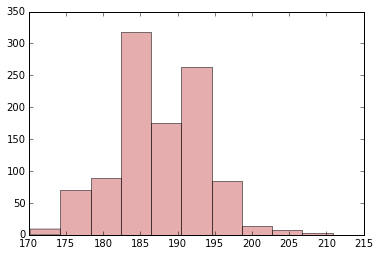

In [354]:
# histogram 그리기
# print plt.hist.__doc__
plt.hist(no_nan_data[:,1], color='indianred', alpha=0.5)

In [364]:
# 사실 mean, sum, sort와 같은 함수들은 파이썬 list에도 있습니다. 다만 차이는 속도! 
# numpy에서는 single data type을 사용하기에 속도가 굉장히 빠르다고 합니다.
print np.array([1,2,3]).dtype
print np.array([1,2,'3']).dtype

int64
|S21


# 본격 Pandas

# 읽을거리 

### dtype
여기 나오는 dtype(데이터 타입)들은 모두 numpy에 구현된 자료형들입니다. 위 index의 type을 찍어봤을때 정수는 int64로, 문자열의 경우 object로 나온 것을 확인 할 수 있었습니다. index64의 경우 8 byte로 64bit = 2^64개의 bit(2**64)의 메모리를 차지합니다. 문자열의 경우 메모리를 얼마나 차지할 지 모르기 때문에, 메모리를 참조하는 방식으로 이루어집니다.

![](http://i.stack.imgur.com/pFF44.png)

### 참고
- http://stackoverflow.com/questions/21018654/strings-in-a-dataframe-but-dtype-is-object
- http://docs.scipy.org/doc/numpy-1.10.1/user/basics.types.html
- http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html